In [29]:
# Import libraries
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt 

#read salary and stats files into salary and player_stats
salary = pd.read_csv("datasets/nba_player_contract_stats.csv", encoding = "ISO-8859-1")
player_stats = pd.read_csv("datasets/nba_player_stats_2020.csv", encoding = "ISO-8859-1")

In [43]:
#Convert currency string to float
salary[salary.columns[3:9]] = salary[salary.columns[3:9]].replace('[\$,]', '', regex=True).astype(float)

salary.head()

,Unnamed: 0,Player,Team,2019-20,2020-21,2021-22,2022-23,2023-24,2024-25,Signed Using,Guaranteed
0,0,Stephen Curry,GSW,40231758.0,43006362.0,45780966.0,NaN,NaN,NaN,Bird Rights,"$129,019,086"
1,1,Chris Paul,OKC,38506482.0,41358814.0,44211146.0,NaN,NaN,NaN,Bird Rights,"$79,865,296"
2,2,Russell Westbrook,HOU,38178000.0,41006000.0,43848000.0,46662000.0,NaN,NaN,Bird Rights,"$123,032,000"
3,3,John Wall,WAS,37800000.0,40824000.0,43848000.0,46872000.0,NaN,NaN,Bird Rights,"$122,472,000"
4,4,James Harden,HOU,37800000.0,40824000.0,43848000.0,46872000.0,NaN,NaN,Bird Rights,"$122,472,000"


In [44]:
player_stats.head()

,Unnamed: 0,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0,Steven Adams,C,26.0,OKC,58.0,58.0,27.0,4.5,7.6,...,0.590,3.4,6.0,9.4,2.4,0.9,1.1,1.5,1.9,10.9
1,1,Bam Adebayo,PF,22.0,MIA,65.0,65.0,34.4,6.3,11.1,...,0.690,2.5,8.0,10.5,5.1,1.2,1.3,2.8,2.5,16.2
2,2,LaMarcus Aldridge,C,34.0,SAS,53.0,53.0,33.1,7.4,15.0,...,0.827,1.9,5.5,7.4,2.4,0.7,1.6,1.4,2.4,18.9
3,3,Nickeil Alexander-Walker,SG,21.0,NOP,41.0,0.0,12.2,1.9,5.5,...,0.607,0.2,1.8,2.0,1.8,0.3,0.2,1.0,1.1,5.1
4,4,Grayson Allen,SG,24.0,MEM,30.0,0.0,16.6,2.6,5.9,...,0.857,0.2,2.0,2.2,1.4,0.2,0.0,0.8,1.2,7.4


In [146]:
#merge data into stats_salary on 'Player' key
stats_salary = pd.merge(player_stats, salary, on='Player')

#Drop unnecessary/duplicate columns
stats_salary.drop(['Unnamed: 0_x', 'Unnamed: 0_y', 'Team'], axis=1, inplace=True)

#rename eFG% ... % symbol causing errors when defining prediction function at end of notebook
stats_salary.rename(columns={'eFG%':'eFGperc'}, inplace=True)

In [158]:
#remove rows containing empty current salary and eFG% fields
stats_salary = stats_salary[stats_salary['2019-20'].notna()]
stats_salary = stats_salary[stats_salary['eFGperc'].notna()]

#remove duplicates
stats_salary.drop_duplicates(inplace= True)

stats_salary.isnull().any()
stats_salary.isnull().sum() / stats_salary.shape[0]

Player          0.000000
Pos             0.000000
Age             0.000000
Tm              0.000000
G               0.000000
GS              0.000000
MP              0.000000
FG              0.000000
FGA             0.000000
FG%             0.000000
3P              0.000000
3PA             0.000000
3P%             0.044335
2P              0.000000
2PA             0.000000
2P%             0.014778
eFGperc         0.000000
FT              0.000000
FTA             0.000000
FT%             0.032841
ORB             0.000000
DRB             0.000000
TRB             0.000000
AST             0.000000
STL             0.000000
BLK             0.000000
TOV             0.000000
PF              0.000000
PTS             0.000000
2019-20         0.000000
2020-21         0.441708
2021-22         0.683087
2022-23         0.855501
2023-24         0.970443
2024-25         0.995074
Signed Using    0.170772
Guaranteed      0.000000
constant        0.000000
dtype: float64

In [159]:
stats_salary.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,PTS,2019-20,2020-21,2021-22,2022-23,2023-24,2024-25,Signed Using,Guaranteed,constant
0,Steven Adams,C,26.0,OKC,58.0,58.0,27.0,4.5,7.6,0.591,...,10.9,25842697.0,27528090.0,NaN,NaN,NaN,NaN,1st Round Pick,"$53,370,787",1.0
1,Bam Adebayo,PF,22.0,MIA,65.0,65.0,34.4,6.3,11.1,0.567,...,16.2,3454080.0,5115492.0,NaN,NaN,NaN,NaN,1st Round Pick,"$8,569,572",1.0
2,LaMarcus Aldridge,C,34.0,SAS,53.0,53.0,33.1,7.4,15.0,0.493,...,18.9,26000000.0,24000000.0,NaN,NaN,NaN,NaN,Cap Space,"$50,000,000",1.0
3,Nickeil Alexander-Walker,SG,21.0,NOP,41.0,0.0,12.2,1.9,5.5,0.339,...,5.1,2964840.0,3113160.0,3261480.0,5009633.0,NaN,NaN,1st Round Pick,"$6,078,000",1.0
4,Grayson Allen,SG,24.0,MEM,30.0,0.0,16.6,2.6,5.9,0.449,...,7.4,2429400.0,2545320.0,4054695.0,NaN,NaN,NaN,1st Round Pick,"$4,974,720",1.0


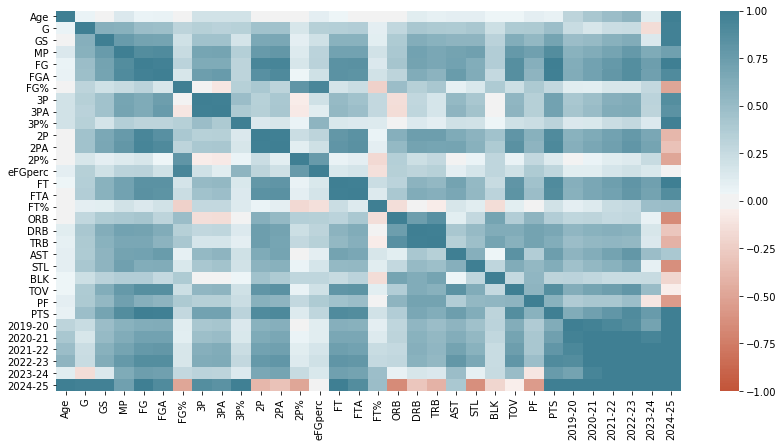

In [152]:
#correlation check
plt.figure(figsize=(14,7))

corrdata = stats_salary

corr = corrdata.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200), 
);

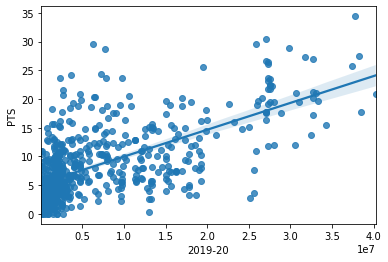

In [51]:
#simple linear regression model
#scatter plot with regression line
sns.regplot(x=stats_salary['2019-20'], y=stats_salary['PTS'])

In [80]:
#simple linear regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [81]:
#set variables need to be in specific format 
X1 = stats_salary['PTS'].values.reshape(-1,1)
y1 = stats_salary['2019-20'].values.reshape(-1,1)

In [82]:
#set variables need to be in specific format 
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=0)

In [83]:
reg = LinearRegression().fit(X_train1, y_train1)
reg.score(X_train1, y_train1)
reg.coef_
y_hat1 = reg.predict(X_train1)

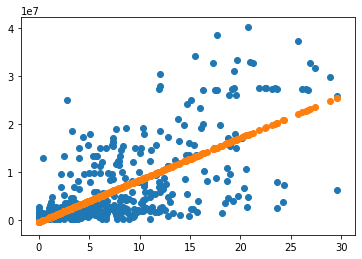

In [84]:
plt.scatter(X_train1,y_train1)
plt.scatter(X_train1,y_hat1)
plt.show()

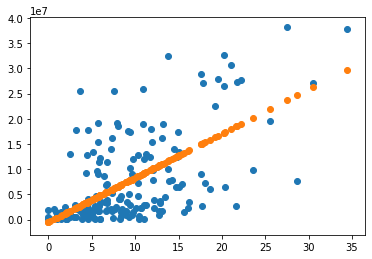

In [85]:
y_hat_test1 = reg.predict(X_test1)
plt.scatter(X_test1, y_test1)
plt.scatter(X_test1, y_hat_test1)
plt.show()

In [156]:
#MSE & RMSE penalize large errors more than MAE 
mae = mean_absolute_error(y_hat_test1,y_test1)
rmse = math.sqrt(mean_squared_error(y_hat_test1,y_test1))
print('Root Mean Squared Error = ',rmse)
print('Mean Absolute Error = ',mae)

Root Mean Squared Error =  6921313.304286677
Mean Absolute Error =  5136332.147021046


In [157]:
import statsmodels.api as sm

stats_salary['constant'] = 1.0

X1b = stats_salary[['constant','PTS']]
y1b = stats_salary['2019-20'].values

X_train1b, X_test1b, y_train1b, y_test1b = train_test_split(X1b, y1b, test_size=0.3, random_state=0)

reg_sm1b = sm.OLS(y_train1b, X_train1b).fit()
reg_sm1b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     253.2
Date:                Mon, 30 Mar 2020   Prob (F-statistic):           4.83e-45
Time:                        16:12:59   Log-Likelihood:                -7299.4
No. Observations:                 426   AIC:                         1.460e+04
Df Residuals:                     424   BIC:                         1.461e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant   -6.779e+04   5.57e+05     -0.122      0.903   -1.16e+06    1.03e+06
PTS         8.504e+05   5.34e+04     15.914      0.000    7.45e+05    9.55e+05
==============================================================================
Omnibus:                       48.374   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.599
Skew:                           0.784   Prob(JB):                     1.27e-15
Kurtosis:                       4.186   Cond. No.                         18.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [136]:
#multiple linear regression
from statsmodels.stats.outliers_influence import variance_inflation_factor

X2 = stats_salary[['constant','PTS','AST','TRB', 'BLK', 'eFGperc']]
y2 = stats_salary['2019-20'].values

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=0)

reg_sm2 = sm.OLS(y_train2, X_train2).fit()
reg_sm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     66.66
Date:                Mon, 30 Mar 2020   Prob (F-statistic):           3.60e-51
Time:                        15:35:26   Log-Likelihood:                -7274.7
No. Observations:                 426   AIC:                         1.456e+04
Df Residuals:                     420   BIC:                         1.459e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant    1.003e+06   1.28e+06      0.782      0.435   -1.52e+06    3.52e+06
PTS         4.581e+05   8.92e+04      5.134      0.000    2.83e+05    6.34e+05
AST          1.39e+06   2.68e+05      5.178      0.000    8.62e+05    1.92e+06
TRB         4.027e+05   2.11e+05      1.905      0.057   -1.28e+04    8.18e+05
BLK         2.874e+06   1.04e+06      2.766      0.006    8.31e+05    4.92e+06
eFGperc    -5.897e+06   2.64e+06     -2.233      0.026   -1.11e+07   -7.07e+05
==============================================================================
Omnibus:                       41.957   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.986
Skew:                           0.671   Prob(JB):                     2.10e-14
Kurtosis:                       4.323   Cond. No.                         107.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [137]:
pd.Series([variance_inflation_factor(X2.values,i) for i in range(X2.shape[1])],index=X2.columns)

constant    17.936766
PTS          3.365039
AST          2.434398
TRB          2.907384
BLK          2.095539
eFGperc      1.176632
dtype: float64

In [138]:
#create predictSalary function
def predictSalary(PTS, AST, TRB, BLK, eFGperc):
    predictedSalary = 1673000 + 534200*PTS + 905100*AST + 674900*TRB + 2874000*BLK + -5897000*eFGperc
    return predictedSalary

In [139]:
#Example: Toronto Raptors guard Fred VanVleet (Free agent this off-season)
predictSalary(17.6, 6.6, 3.8, 0.3, 0.503)

17509209.0

In [ ]:
#Predicted yearly salary = $17,509,209.00